In [2]:
import os
import os.path as osp
import random
import torch
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import pytorch_warmup as warmup
from scipy.stats import pearsonr, spearmanr, kendalltau
import wandb
from datasets import create_datalists, create_datasets
from models.get_models import get_model
import output
from validate import valid
import analysis
from analysis.util import plot_dist

In [3]:
configs = {
    'pretrain': 'None',
    'img_size': 512,
    'model': 'Resnet18',
    'epochs': 100,
    'batch_size': 32,
    'weight_decay': 1e-3,
    'lr': 1e-4,
    'min_lr': 0.000006463,
    'RandomHorizontalFlip': True,
    'RandomVerticalFlip': True,
    'RandomRotation': True,
    'ZoomIn': False,
    'ZoomOut': False,
    'use_mix': False,
    'use_avg': False,
    'XShift': False,
    'YShift': False,
    'RandomShear': False,
    'max_shear': 30,  # value in degrees
    'max_shift': 0.5,
    'rotation_angle': 3,
    'zoomin_factor': 0.95,
    'zoomout_factor': 0.05,
}

imgs_list, label_list = create_datalists()

test_dataset, _ = create_datasets(imgs_list, label_list, configs, final_train=True,
                                  patients_out=False, patient_ids_out=[1, 2, 3])
print(len(test_dataset))

model = get_model({'model': 'Resnet18', 'pretrain': 'None'})
model.load_state_dict(torch.load(osp.join(osp.dirname(output.__file__), 'Resnet18_epoch_150_1foldout.pth'), map_location="cpu"), strict=True)
model = model.cuda()

bad_pred_indices = valid(model, test_dataset, 0, 0, 0, False, loss_threshold=0.5)
len(bad_pred_indices)

1000


In [4]:
patient_ids = np.loadtxt(osp.join(osp.dirname(analysis.__file__), 'labels.txt'))
per_patient_worst = []
per_patient_worst_labels = []

for p in range(4):
    patient_ids_out = [p]
    patient_indices = [i for i, x in enumerate(patient_ids) if x in patient_ids_out]
    #
    # plot_dist(labels)
    per_patient_worst_indices = [i for i in bad_pred_indices if i in patient_indices]
    per_patient_worst.append(per_patient_worst_indices)

    labels = [label_list[i] for i in per_patient_worst_indices]
    per_patient_worst_labels.append(labels)
    plot_dist(labels)

C:\ProgramData\Anaconda3\envs\CTImageQuality\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\CTImageQuality\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
validation: 100%|██████████| 1000/1000 [00:31<00:00, 31.83it/s, plcc=0.977, srocc=0.977, krocc=0.885, overall=2.84, std=0.228]


40

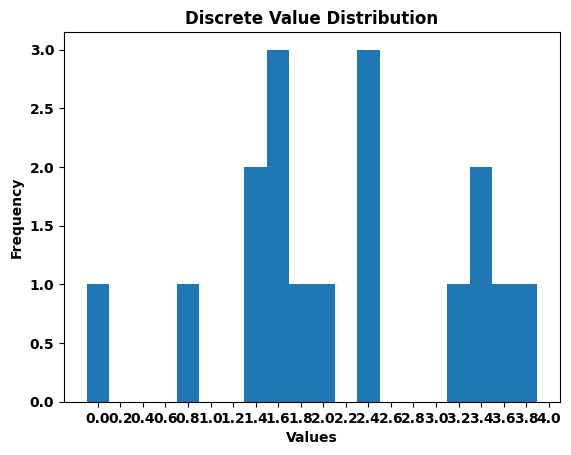

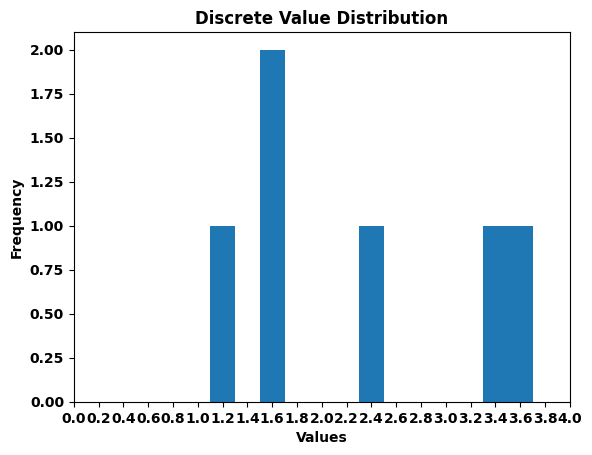

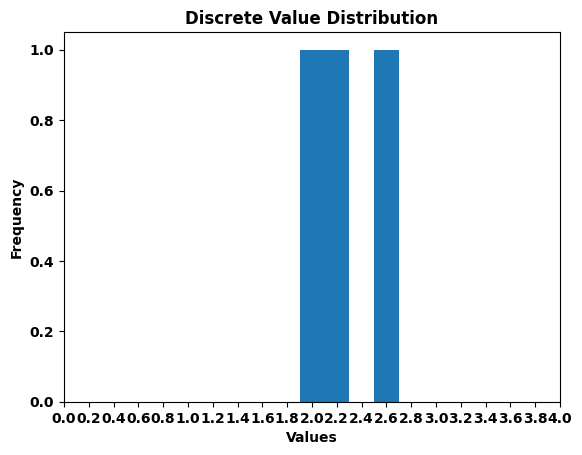

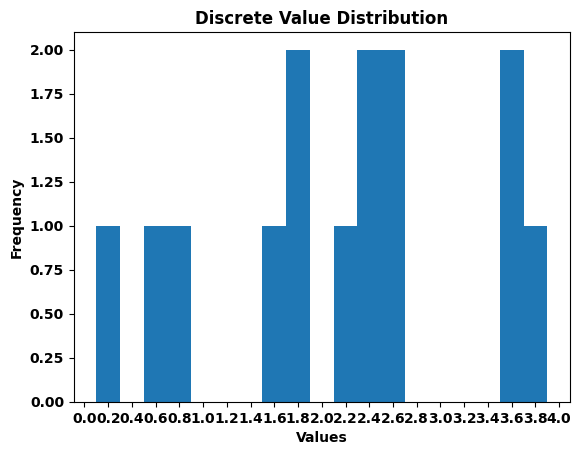

In [5]:
for p in range(4):
    print(len(per_patient_worst[p]))

17
6
3
14
